sphere function using binary GA

Best Solution (x): [-0.00015259 -0.00076295 -0.00015259 -0.00137331]
Minimum Value (f(x)): 2.5146476918336794e-06


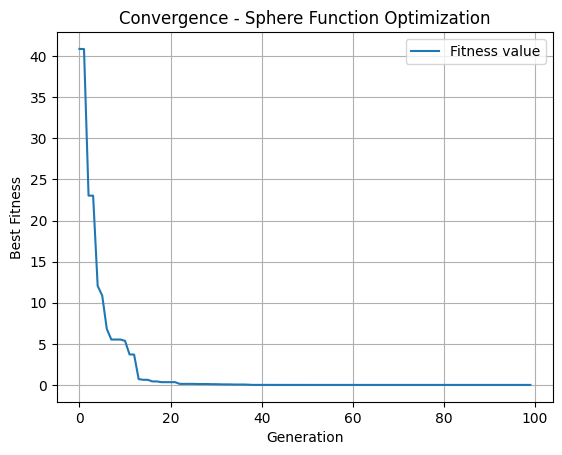

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# GA Parameters
num_variables = 4
bits_per_variable = 16
pop_size = 50
generations = 100
crossover_rate = 0.9
mutation_rate = 1 / (num_variables * bits_per_variable)
lower_bound = -10
upper_bound = 10

total_bits = num_variables * bits_per_variable

def decode(individual):
    decoded = []
    for i in range(num_variables):
        start = i * bits_per_variable
        end = start + bits_per_variable
        substring = individual[start:end]
        integer = int("".join(str(b) for b in substring), 2)
        value = lower_bound + (upper_bound - lower_bound) * integer / (2**bits_per_variable - 1)
        decoded.append(value)
    return np.array(decoded)

def fitness(individual):
    x = decode(individual)
    return np.sum(x ** 2)  # Sphere function

def initialize_population():
    return np.random.randint(0, 2, (pop_size, total_bits))

def tournament_selection(pop, fits):
    i, j = np.random.randint(0, pop_size, 2)
    return pop[i] if fits[i] < fits[j] else pop[j]

def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        point = np.random.randint(1, total_bits - 1)
        return np.concatenate((parent1[:point], parent2[point:])), \
               np.concatenate((parent2[:point], parent1[point:]))
    return parent1.copy(), parent2.copy()

def mutate(individual):
    for i in range(total_bits):
        if np.random.rand() < mutation_rate:
            individual[i] = 1 - individual[i]

def binary_ga():
    population = initialize_population()
    best_fitness = []
    best_solution = None
    best_value = float('inf')

    for gen in range(generations):
        fitness_values = np.array([fitness(ind) for ind in population])
        next_gen = []

        # Track best
        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < best_value:
            best_value = fitness_values[min_idx]
            best_solution = decode(population[min_idx])

        best_fitness.append(best_value)

        # Elitism: carry best individual
        next_gen.append(population[min_idx])

        while len(next_gen) < pop_size:
            parent1 = tournament_selection(population, fitness_values)
            parent2 = tournament_selection(population, fitness_values)
            child1, child2 = crossover(parent1, parent2)
            mutate(child1)
            mutate(child2)
            next_gen.extend([child1, child2])

        population = np.array(next_gen[:pop_size])

    return best_solution, best_value, best_fitness

# Run GA
solution, value, convergence = binary_ga()

print("Best Solution (x):", solution)
print("Minimum Value (f(x)):", value)

# Plotting convergence
plt.plot(convergence, label="Fitness value")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Convergence - Sphere Function Optimization")
plt.grid(True)
plt.legend()
plt.show()


binary coded genetic algorithm using deap library

In [2]:
import os
import numpy as np
import random
from deap import base, creator, tools, algorithms
import csv

# === Folder Path ===
GAP_FOLDER = r"C:\Users\MD KAIF\Desktop\lab_assignments\ec_lab\gap_dataset_files"
binary_ga_results=[]
# === GA Parameters ===
POP_SIZE = 100
GENS = 200
CX_PROB = 0.9
MUT_PROB = 0.05
TOURN_SIZE = 3

# === GAP Parser ===
def parse_gap_file(filepath):
    with open(filepath, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    index = 0
    num_instances = int(lines[index])
    index += 1
    instances = []

    for _ in range(num_instances):
        m, n = map(int, lines[index].split())
        index += 1

        util, res = [], []
        for _ in range(m):
            row = []
            while len(row) < n:
                row += list(map(int, lines[index].split()))
                index += 1
            util.append(row)
        for _ in range(m):
            row = []
            while len(row) < n:
                row += list(map(int, lines[index].split()))
                index += 1
            res.append(row)
        cap = []
        while len(cap) < m:
            cap += list(map(int, lines[index].split()))
            index += 1

        instances.append((m, n, np.array(util), np.array(res), np.array(cap)))
    return instances

# === Decode + Repair ===
def decode(ind, n_users, m_servers):
    bpg = int(np.ceil(np.log2(m_servers)))
    alloc = []
    for i in range(n_users):
        bits = ind[i * bpg:(i + 1) * bpg]
        val = int("".join(map(str, bits)), 2)
        alloc.append(val % m_servers)
    return alloc

def repair_allocation(alloc, res, cap):
    m, n = res.shape
    usage = np.zeros(m)
    for u, s in enumerate(alloc):
        usage[s] += res[s][u]
    for s in range(m):
        if usage[s] > cap[s]:
            for u in range(n):
                if alloc[u] == s:
                    for new_s in range(m):
                        if new_s != s and usage[new_s] + res[new_s][u] <= cap[new_s]:
                            usage[s] -= res[s][u]
                            usage[new_s] += res[new_s][u]
                            alloc[u] = new_s
                            break
                    if usage[s] <= cap[s]:
                        break
    return alloc, usage

# === Fitness ===
def evaluate(ind, m, n, util, res, cap):
    alloc = decode(ind, n, m)
    alloc, usage = repair_allocation(alloc, res, cap)
    for s in range(m):
        if usage[s] > cap[s]:
            return 0,
    total = sum(util[alloc[u]][u] for u in range(n))
    return total,

# === Binary GA Solver ===
def solve_gap_instance(m, n, util, res, cap, track_convergence=False):
    bpg = int(np.ceil(np.log2(m)))
    chrom_len = bpg * n

    if "FitnessMax" not in creator.__dict__:
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if "Individual" not in creator.__dict__:
        creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, chrom_len)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.01)
    toolbox.register("select", tools.selTournament, tournsize=TOURN_SIZE)
    toolbox.register("evaluate", evaluate, m=m, n=n, util=util, res=res, cap=cap)

    pop = toolbox.population(n=POP_SIZE)
    convergence = []

    for gen in range(GENS):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
        fits = list(map(toolbox.evaluate, offspring))
        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit
        pop = toolbox.select(offspring, k=len(pop))

        if track_convergence:
            best_fit = max(ind.fitness.values[0] for ind in pop)
            convergence.append(best_fit)

    best = tools.selBest(pop, k=1)[0]
    best_alloc = decode(best, n, m)
    best_alloc, usage = repair_allocation(best_alloc, res, cap)
    total = sum(util[best_alloc[u]][u] for u in range(n))

    if track_convergence:
        return best_alloc, total, convergence
    else:
        return best_alloc, total


# === Main Execution ===
binary_ga_results = []

def sort_key(filename):
    return int(''.join(filter(str.isdigit, filename)))

for file in sorted(os.listdir(GAP_FOLDER), key=sort_key):
    if file.endswith(".txt"):
        filepath = os.path.join(GAP_FOLDER, file)
        instances = parse_gap_file(filepath)

        for idx, (m, n, util, res, cap) in enumerate(instances):
            try:
                best_alloc, total = solve_gap_instance(m, n, util, res, cap)
                print(f"Processing Instance {idx + 1} from {file}")
                print(f"Task Assignments: {best_alloc}")
                print(f"Total Binary GA Utility: {float(total)}\n")

                binary_ga_results.append((file, idx + 1, best_alloc, float(total)))
            except Exception as e:
                print(f"⚠ Error in instance {idx + 1} from {file}: {e}\n")

# === Save Binary GA Results to CSV ===
output_file = r"C:\Users\MD KAIF\Desktop\assignment3_soln\binary_ga_results.csv"
with open(output_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Filename", "Instance", "Assignments", "Total_Profit"])
    for row in binary_ga_results:
        writer.writerow(row)

    print(f"\n✅ Results saved to {output_file}")

Processing Instance 1 from gap1.txt
Task Assignments: [1, 1, 2, 3, 0, 4, 0, 1, 0, 3, 2, 3, 0, 4, 2]
Total Binary GA Utility: 322.0

Processing Instance 2 from gap1.txt
Task Assignments: [4, 0, 0, 2, 2, 4, 2, 1, 0, 4, 2, 1, 3, 1, 3]
Total Binary GA Utility: 302.0

Processing Instance 3 from gap1.txt
Task Assignments: [2, 0, 4, 3, 2, 3, 4, 0, 0, 1, 3, 0, 4, 1, 1]
Total Binary GA Utility: 319.0

Processing Instance 4 from gap1.txt
Task Assignments: [1, 4, 0, 1, 2, 4, 4, 1, 1, 3, 0, 2, 4, 3, 1]
Total Binary GA Utility: 325.0

Processing Instance 5 from gap1.txt
Task Assignments: [1, 3, 2, 3, 4, 4, 4, 2, 2, 1, 0, 3, 0, 4, 0]
Total Binary GA Utility: 318.0

Processing Instance 1 from gap2.txt
Task Assignments: [2, 4, 0, 3, 2, 4, 2, 3, 0, 3, 4, 1, 2, 0, 3, 0, 3, 1, 1, 0]
Total Binary GA Utility: 410.0

Processing Instance 2 from gap2.txt
Task Assignments: [4, 0, 4, 3, 0, 1, 1, 3, 1, 2, 2, 1, 0, 4, 4, 3, 3, 3, 2, 0]
Total Binary GA Utility: 413.0

Processing Instance 3 from gap2.txt
Task Assig

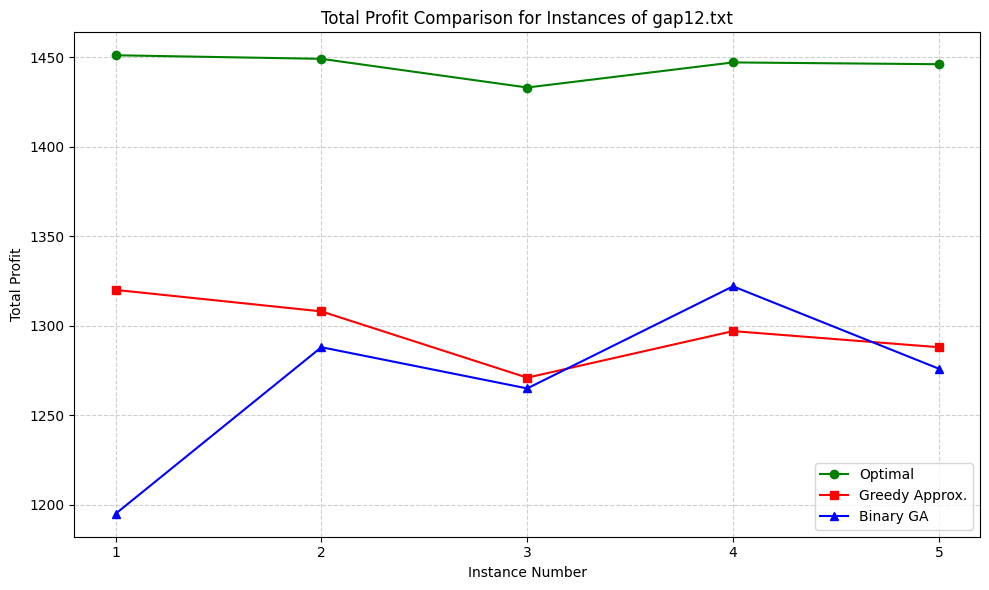


✅ Plot saved successfully at: c:\Users\MD KAIF\Desktop\assignment3_soln\gap12_comparison.png


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# File paths
optimal_file = r"C:\Users\MD KAIF\Desktop\lab_assignments\ec_lab\optimal_results.csv"
approximate_file = r"C:\Users\MD KAIF\Desktop\lab_assignments\ec_lab\greedy_results.csv"
binary_file = r"C:\Users\MD KAIF\Desktop\assignment3_soln\binary_ga_results.csv"

# Load and clean CSVs
def load_and_clean_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df['Filename'] = df['Filename'].astype(str).str.strip()
    df['Instance'] = pd.to_numeric(df['Instance'], errors='coerce').astype('Int64')  # robust conversion
    df['Total_Profit'] = df['Total_Profit'].astype(str).str.replace(',', '').astype(float)
    return df

df_optimal = load_and_clean_csv(optimal_file)
df_approx = load_and_clean_csv(approximate_file)
df_binary = load_and_clean_csv(binary_file)

# Filter for gap12.txt
filename = 'gap12.txt'
df_optimal_gap12 = df_optimal[df_optimal['Filename'] == filename]
df_approx_gap12 = df_approx[df_approx['Filename'] == filename]
df_binary_gap12 = df_binary[df_binary['Filename'] == filename]


# Get common instances
common_instances = sorted(
    set(df_optimal_gap12['Instance'].dropna()) &
    set(df_approx_gap12['Instance'].dropna()) &
    set(df_binary_gap12['Instance'].dropna())
)

# Extract values
optimal_values = [df_optimal_gap12[df_optimal_gap12['Instance'] == i]['Total_Profit'].values[0] for i in common_instances]
approx_values = [df_approx_gap12[df_approx_gap12['Instance'] == i]['Total_Profit'].values[0] for i in common_instances]
binary_values = [df_binary_gap12[df_binary_gap12['Instance'] == i]['Total_Profit'].values[0] for i in common_instances]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(common_instances, optimal_values, marker='o', label='Optimal', color='green')
plt.plot(common_instances, approx_values, marker='s', label='Greedy Approx.', color='red')
plt.plot(common_instances, binary_values, marker='^', label='Binary GA', color='blue')

plt.title('Total Profit Comparison for Instances of gap12.txt')
plt.xlabel('Instance Number')
plt.ylabel('Total Profit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(common_instances)
plt.tight_layout()

# Save plot
output_path = os.path.join(os.getcwd(), "gap12_comparison.png")
plt.savefig(output_path, dpi=300)
plt.show()

print(f"\n✅ Plot saved successfully at: {output_path}")


now convergence graph



🔍 GAP12 - Instance 1 Utility Comparison:
Optimal Utility:        1451.0
Greedy Approximation:   1320.0
Binary GA Utility:      1272


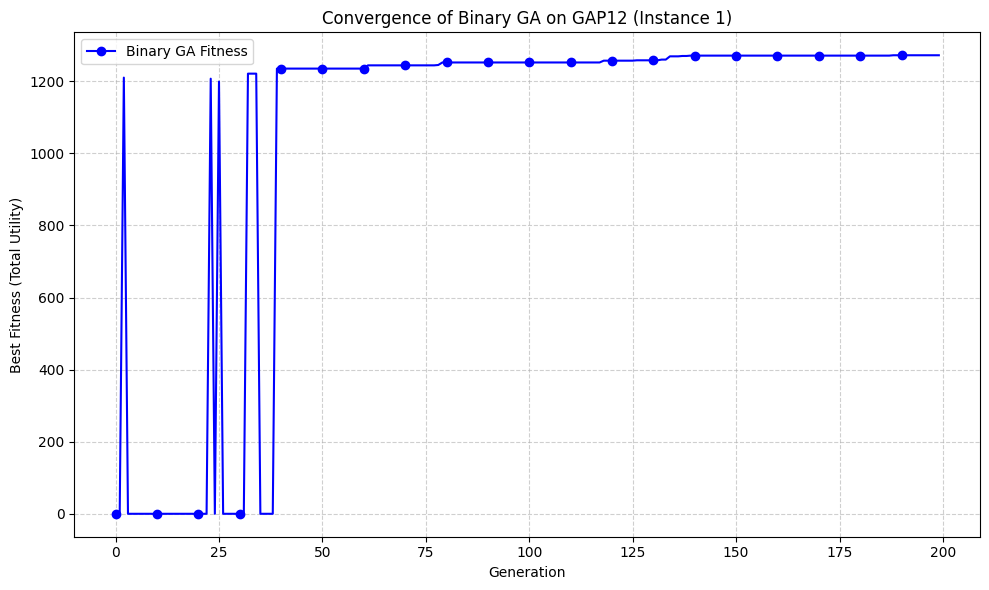


✅ Convergence plot saved at: c:\Users\MD KAIF\Desktop\assignment3_soln\gap12_binaryga_convergence.png


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# === Paths ===
gap12_file = r"C:\Users\MD KAIF\Desktop\assignment4_soln\gap_dataset_files\gap12.txt"
optimal_file = r"C:\Users\MD KAIF\Desktop\assignment4_soln\optimal_results.csv"
approx_file = r"C:\Users\MD KAIF\Desktop\assignment4_soln\greedy_results.csv"

# === Load GAP12 ===
instances = parse_gap_file(gap12_file)
m, n, util, res, cap = instances[0]  # You can loop or change index for other instances

# === Run Binary GA with convergence tracking ===
binary_alloc, binary_total, binary_convergence = solve_gap_instance(m, n, util, res, cap, track_convergence=True)

# === Load CSV Results for GAP12 ===
def load_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df['Filename'] = df['Filename'].astype(str).str.strip()
    df['Instance'] = pd.to_numeric(df['Instance'], errors='coerce').astype('Int64')
    df['Total_Profit'] = df['Total_Profit'].astype(str).str.replace(',', '').astype(float)
    return df

df_opt = load_csv(optimal_file)
df_appx = load_csv(approx_file)

# Filter for gap12 instance 1
filename = 'gap12.txt'
df_opt_gap12 = df_opt[(df_opt['Filename'] == filename) & (df_opt['Instance'] == 1)]
df_appx_gap12 = df_appx[(df_appx['Filename'] == filename) & (df_appx['Instance'] == 1)]

# Extract values
optimal_total = df_opt_gap12['Total_Profit'].values[0]
approx_total = df_appx_gap12['Total_Profit'].values[0]

# === Print Comparison Table ===
print("\n🔍 GAP12 - Instance 1 Utility Comparison:")
print(f"Optimal Utility:        {optimal_total}")
print(f"Greedy Approximation:   {approx_total}")
print(f"Binary GA Utility:      {binary_total}")

# === Plot Convergence ===
plt.figure(figsize=(10, 6))
plt.plot(binary_convergence, label='Binary GA Fitness', color='blue', marker='o', markevery=10)
plt.title("Convergence of Binary GA on GAP12 (Instance 1)")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Total Utility)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plot_path = os.path.join(os.getcwd(), "gap12_binaryga_convergence.png")
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"\n✅ Convergence plot saved at: {plot_path}")


In [6]:
import pandas as pd

# Save convergence list to CSV
binary_df = pd.DataFrame({'Generation': list(range(1, len(binary_convergence)+1)),
                          'Fitness': binary_convergence})
binary_df.to_csv(r"C:\Users\MD KAIF\Desktop\assignment4_soln\binary_ga_convergence_gap12.csv", index=False)
print("✅ Binary GA convergence saved.")


✅ Binary GA convergence saved.
